## Fast computation of the minimum set of HiPSCat partition pairs for inner joins

Optimized for speed, memory footprint, and minimal dependencies. Only relies on numpy and healpy (note: removing healpy should be trivial).

Author: Mario Juric, <mjuric@astro.washington.edu><br>
When: April 2024<br>
Where: vombat.irb (Lovro Palaversa's cluster @ IRB)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import healpy as hp

pd.set_option('display.max_columns', None)

Let's construct the *skymaps* (== map of counts in pixels at some healpix order, or their boolean version that only stores True/False depending on whether there's data in that pixel) and *order maps* (== map of orders at which data falling into a particular high-order healpix pixel has been stored; -1 if there's no data in that pixel) from some existing catalogs.

The skymap should be constructed at some high order, about as high as a plausible HIPSCat catalog would go (typically 9 or 10).

Note: these functions are just to bootstrap this notebook; these maps should be stored and kept within the HiPSCat metadata.

In [2]:
def compute_omap(path):
    # Infer the HiPS hierarchy from scanning the directory tree
    import glob, re
    maps = dict()
    npart = 0
    for fn in glob.glob(f"{path}/*/*/*.parquet"):
        if m:= re.search(r'Norder=(\d+)/Dir=\d+/Npix=(\d+)', fn):
            o, ipix = map(int, m.group(1, 2))
            if o not in maps:
                maps[o] = np.zeros(hp.order2npix(o), dtype=int)
            maps[o][ipix] = o + 1
            npart += 1

    # Flatten the result into a high-order map
    order_out = max(maps.keys())
    nside_out = hp.order2nside(order_out)
    omap = np.zeros(hp.order2npix(order_out), dtype=int)
    for o, m in maps.items():
        upscaled = hp.ud_grade(m, nside_out, dtype=int, order_in='NESTED', order_out='NESTED')
        omap[:] += upscaled

    return (omap - 1).astype('i1'), npart

def skymap_aux(fn, order):
    nside = hp.order2nside(order)

    df = pd.read_parquet(fn, columns='ra dec'.split())
    ipix = hp.ang2pix(nside, df["ra"], df["dec"], nest=True, lonlat=True)
    i, ct = np.unique(ipix, return_counts=True)

    return i, ct

def compute_skymap(path, order):
    from functools import partial
    from rich.progress import track
    import glob, psutil
    import multiprocessing as mp

    img = np.zeros(hp.order2npix(order), dtype=int)
    fns = list(glob.glob(f"{path}/*/*/*.parquet"))

    ncores = psutil.cpu_count(logical=False)
    with mp.Pool(processes=ncores) as pool:
        for i, ct in track(pool.imap_unordered(partial(skymap_aux, order=order), fns), total=len(fns)):
            img[i] += ct

    return img

cat1fn = "catalogs/trilegal"
cat2fn = "catalogs/trilegal-flip"

omap1, npart1 = compute_omap(cat1fn)
omap2, npart2 = compute_omap(cat2fn)

skymap1 = compute_skymap(cat1fn, order=9).astype(bool)
skymap2 = compute_skymap(cat2fn, order=9).astype(bool)

Output()

Output()

Prove that the maps have a small memory footprint, even when made at a relatively high order:

In [3]:
print(f"Catalog 1: order={hp.npix2order(len(omap1))}, npart={npart1}, omap1 size={omap1.nbytes/1024/1024}MB, skymap1 size={skymap1.nbytes/1024/1024}MB")
print(f"Catalog 2: order={hp.npix2order(len(omap2))}, npart={npart2}, omap2 size={omap1.nbytes/1024/1024}MB, skymap2 size={skymap1.nbytes/1024/1024}MB")

Catalog 1: order=9, npart=4589, omap1 size=3.0MB, skymap1 size=3.0MB
Catalog 2: order=9, npart=4589, omap2 size=3.0MB, skymap2 size=3.0MB


Visualize:

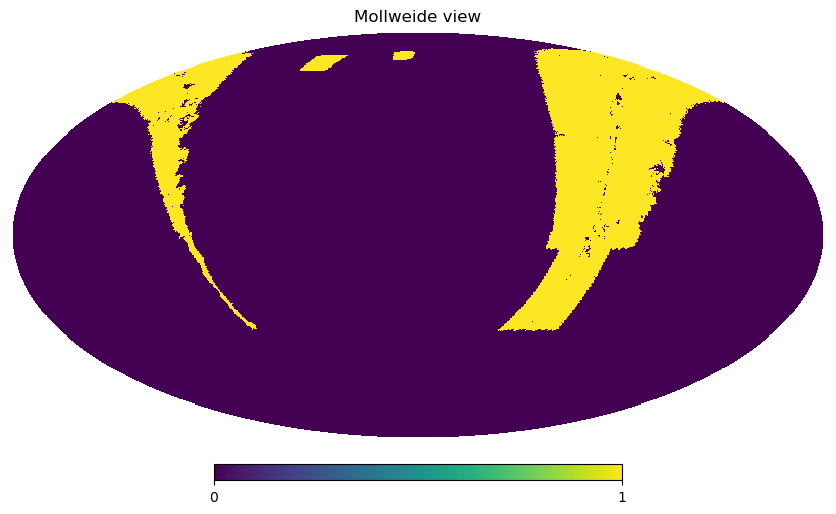

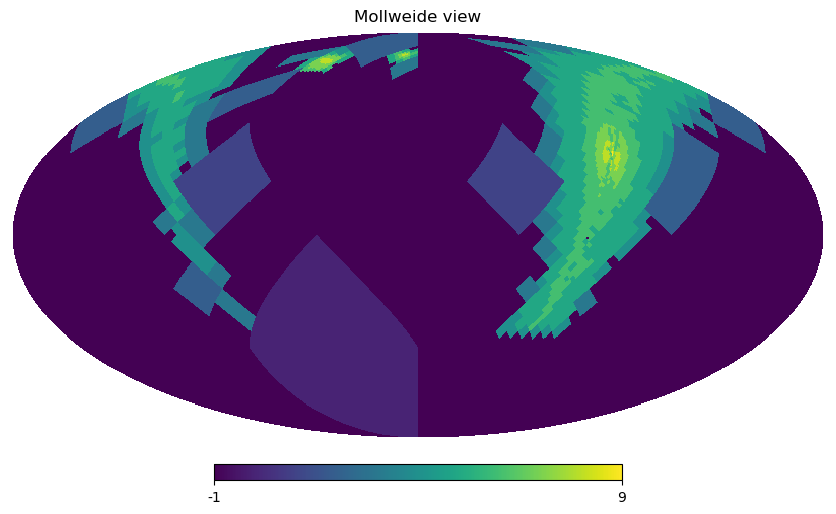

In [4]:
hp.mollview(skymap2, nest=True)
hp.mollview(omap2, nest=True)

Some utility functions -- rescale (that is, change the order of) a healpix map (up or down).

This implementation should be faster (& more predictable) than `hp.ud_grade`.

In [5]:
def hp_rescale(img, order_out):
    #
    # Change the order of a healpix image. This function has different
    # behaviors depending on whether the image is upscaled or downscaled.
    # Maintains dtype. If order_out is equal to existing order, no copy
    # is made.
    #
    # upscaling: higher order pixels are filled with the value of the
    #            value of the lower-order pixel. I.e., for Δo=1 change:
    #                [... 2 ...] -> [... 2 2 2 2 ...]
    #
    # downscaling: lower order pixel is filled with the *sum* of lower order
    #              pixels. I.e., for Δo=1 change:
    #                [... 1 3 5 7 ...] -> [ ... 16 ... ]
    #              WARNING: the dtype of the input img is used for the accumulator.
    #                This could cause overflows if input dtype is narrow.
    #
    # An identity transformation requires division by 2**(2*|o1-o2\). Example:
    #
    #   o2, o1 = 2, 1
    #   x1 = np.arange(hp.order2npix(o1))
    #   x2 = hp_rescale(hp_rescale(x1, o2), o1) >> (2*np.abs(o2-o1))
    #   print(f"{x1}\n{x2}")
    #
    #   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    #    24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
    #   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    #    24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
    #
    o = (int(np.log2(len(img) // 3)) >> 1) - 1 ## this is a fast hp.npix2order impl.

    if order_out > o:
        # upscale
        dim2 = 1 << 2*(order_out-o)
        return np.repeat(img[:, None], dim2, axis=1).flatten()
    elif order_out < o:
        # downscale
        dim2 = 1 << 2*(o-order_out)
        return img.reshape((len(img) // dim2, dim2)).sum(axis=1, dtype=img.dtype)

    return img

# o2, o1 = 2, 1
# x1 = np.arange(hp.order2npix(o1))
# x2 = hp_rescale(hp_rescale(x1, o2), o1) >> (2*np.abs(o2-o1))
# print(f"{x1}\n{x2}")
# hp.mollview(x, nest=True)

This is what we came here for... the fast routine for calculation of partition pairs needed to compute a join:

In [28]:
def compute_join_pairs(skymap1, skymap2, omap1, omap2):
    # Compute the partition pairs needed to perform an inner join
    # between two tables. Do it quickly (~10-100ms, even for large
    # catalogs).
    #
    # Inputs:
    #  - skymap1/2: high healpix-order counts maps of both catalogs.
    #  - omap1/2: order maps of both catalogs
    #
    # For best performance (both speed & memory):
    #  - have all skymaps/omaps at the same order.
    #  - have all omaps as dtype='i1'
    #  - have the skymaps as dtype=bool (i.e., True if there's data
    #    in that pixel, false otherwise).
    # If these are not satisfied, this function will convert the input
    # as needed, at some performance cost.
    #
    # Author: mjuric@uw.edu
    #

    maxlen = max(len(omap1), len(omap2), len(skymap1), len(skymap2))
    o = hp.npix2order(maxlen)

    skymap1 = hp_rescale(skymap1, o).astype(bool, copy=False)
    skymap2 = hp_rescale(skymap2, o).astype(bool, copy=False)
    omap1   = hp_rescale(omap1,   o).astype('i1', copy=False)
    omap2   = hp_rescale(omap2,   o).astype('i1', copy=False)

    # Pixels on the sky where there's overlapping data
    mask, = np.nonzero(skymap1 & skymap2)
    mask = mask.view('u8') ## otherwise subsequent bit shifting won't work correctly

    ## find orders of those pixels, in both catalogs
    o1 = omap1[mask].astype('u8') ## need to widen for subsequent bitshifting to work
    o2 = omap2[mask].astype('u8') ## need to widen for subsequent bitshifting to work
    
    ## Find Npixel numbers for those pixels, in both catalogs
    ipix1 = mask >> (2*(o-o1))
    ipix2 = mask >> (2*(o-o2))

    if o <= 12: ## Fast path
        ## pack it all into a 64-bit integer for _really_ fast np.unique (~15x faster than multi-D array variant)
        ## bit layout: [o1|4bits][ipix1|28bits][o2|4bits][ipix2|28bits]
        ## works for order <= 12
        combined  = ipix2
        combined |=    o2 << 28
        combined |= ipix1 << 32
        combined |=    o1 << 60
        pairs = np.unique(combined)

        ## unpack
        ipix2 = pairs & 0x00000000_0FFFFFFF
        ipix1 = pairs & 0x0FFFFFFF_00000000; ipix1 >>= 32
        o2    = pairs & 0x00000000_F0000000; o2    >>= 28
        o1    = pairs >> 60
    else: ## Universal path
        combined = np.vstack([o1, ipix1, o2, ipix2], dtype='u4')
        pairs = np.unique(combined, axis=1)

        o1, ipix1, o2, ipix2 = pairs.astype('u8') # convert to u8 to maintain the same return datatype as the fast variant

    return (o1, ipix1, o2, ipix2)

## Large catalog test

In [29]:
(o1, ipix1, o2, ipix2) = compute_join_pairs(skymap1, skymap2, omap1, omap2)
df = pd.DataFrame(dict(o1=o1, ipix1=ipix1, o2=o2, ipix2=ipix2))
df

,o1,ipix1,o2,ipix2
0,1,47,6,48778
1,1,47,6,48779
2,1,47,6,48800
3,1,47,6,48801
4,1,47,6,48802
...,...,...,...,...
872,6,30716,5,7679
873,6,30717,5,7679
874,6,30718,5,7679
875,6,30719,5,7679


Let's do some profiling (total speed & line-by-line):

In [30]:
%timeit compute_join_pairs(skymap1, skymap2, omap1, omap2)

4.53 ms ± 9.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%load_ext line_profiler

In [10]:
%lprun -f compute_join_pairs [compute_join_pairs(skymap1, skymap2, omap1, omap2) for _ in range(1000)]

Timer unit: 1e-09 s

Total time: 4.56861 s
File: /tmp/ipykernel_3670557/3880936369.py
Function: compute_join_pairs at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def compute_join_pairs(skymap1, skymap2, omap1, omap2):
     2                                               # Compute the partition pairs needed to perform an inner join
     3                                               # between two tables. Do it quickly (~10-100ms, even for large
     4                                               # catalogs).
     5                                               #
     6                                               # Inputs:
     7                                               #  - skymap1/2: high healpix-order counts maps of both catalogs.
     8                                               #  - omap1/2: order maps of both catalogs
     9                                               #
    10                 

Visualize the result. Semi-transparent overplotting of the selected partitions from both catalogs:

In [11]:
## Quick visualization utilities

def flatten_omap(maps, order):
    # Flatten the result into a high-order map
    nside = hp.order2nside(order)
    omap = np.zeros(hp.order2npix(order), dtype=int)
    for o, m in maps.items():
        upscaled = hp.ud_grade(m, nside, dtype=int, order_in='NESTED', order_out='NESTED')
        omap[:] += upscaled

    return omap - 1

def viz_join(o1, ipix1, o2, ipix2):
    maps1 = dict()
    for o in np.unique(o1).astype('int'):
        h = np.zeros(hp.order2npix(o), dtype=int)
        ipix = ipix1[o1 == o]
        h[ipix] = o + 1
        maps1[o] = h
    h1 = flatten_omap(maps1, order=9).astype(float)
    h1[h1 == -1] = hp.UNSEEN
    
    maps2 = dict()
    for o in np.unique(o2).astype('int'):
        h = np.zeros(hp.order2npix(o), dtype=int)
        ipix = ipix2[o2 == o]
        h[ipix] = o + 1
        maps2[o] = h
    h2 = flatten_omap(maps2, order=9).astype(float)
    h2[h2 == -1] = hp.UNSEEN
    
    from matplotlib import cm
    import matplotlib.pyplot as plt
    
    hp.mollview(h1, nest=True, min=-3, max=9, cmap=cm.Blues, badcolor='w', alpha=np.full(len(h2), 0.5))
    hp.mollview(h2, nest=True, min=-3, max=9, cmap=cm.Reds,  badcolor='w', reuse_axes=True, alpha=np.full(len(h2), 0.5), cbar=False)
    hp.graticule()

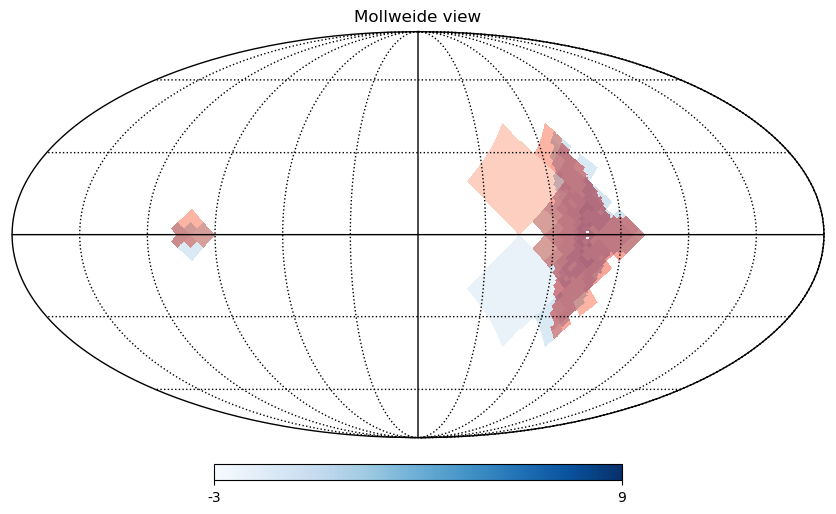

In [12]:
viz_join(o1, ipix1, o2, ipix2)

## Large + small catalog test

First, make a mock sparse catalog.

We'll create a grid of (ra, dec) sources, 10 x 10 degree apart, randomized a little around the grid vertices.

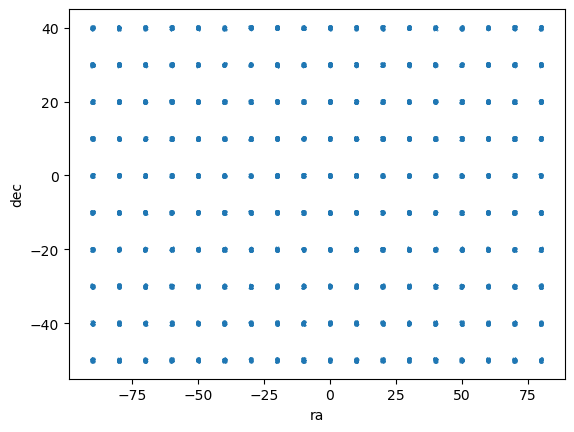

In [13]:
np.random.seed(42)
ra, dec = np.meshgrid(np.arange(-90, 90, 10), np.arange(-50, 50, 10))
ra, dec = np.repeat(ra.flatten().astype(float), 100), np.repeat(dec.flatten().astype(float), 100)
ra += np.random.random(len(ra)) - 0.5
dec += np.random.random(len(dec)) - 0.5
plt.scatter(ra, dec, s=0.1)
plt.xlabel("ra")
plt.ylabel("dec");

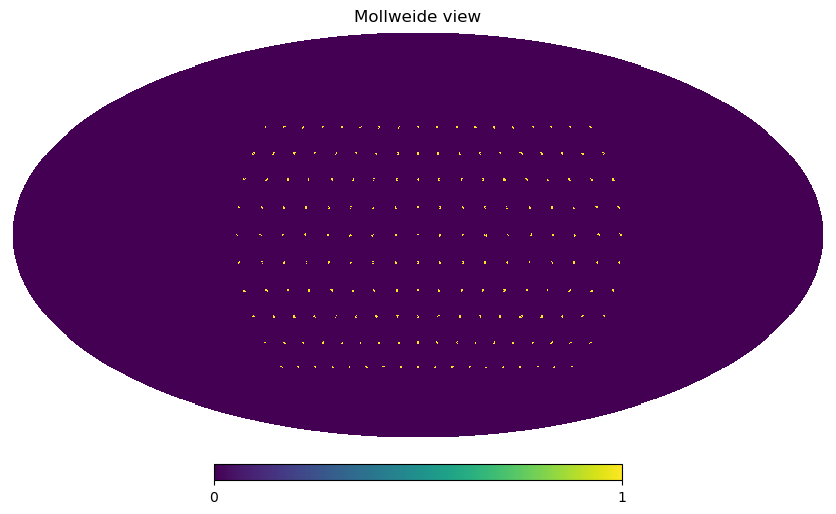

In [14]:
# Construct the skymap for this catalog. We'll force it to a high order
# (this is the crucial bit -- skymaps must be at a higher resolution than
# the partitioning)
oo = 9
nside = hp.order2nside(oo)
sm = np.zeros(hp.order2npix(oo), dtype=int)
ipix = hp.ang2pix(nside, ra, dec, nest=True, lonlat=True)
i, ct = np.unique(ipix, return_counts=True)
sm[i] += ct

# convert to boolean (saves memory and speeds up the join computation)
sm = sm.astype(bool)
hp.mollview(sm, nest=True, badcolor='w')

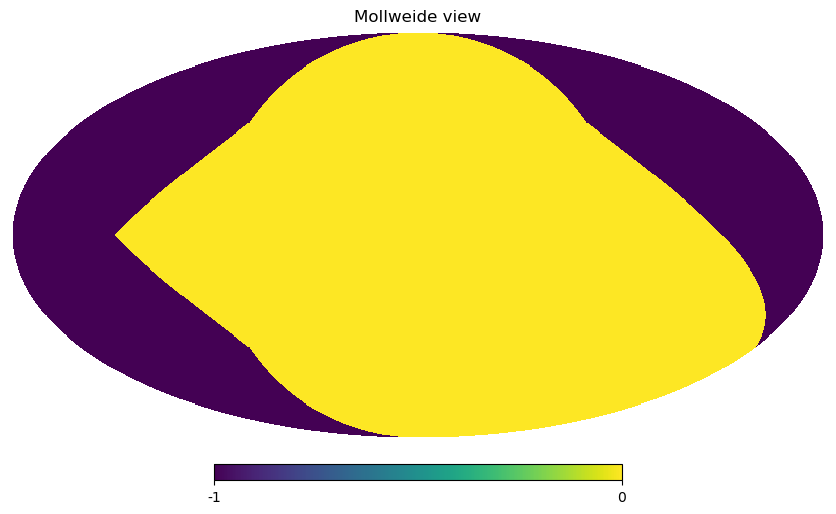

In [20]:
# Construct the order map for this catalog. Pretend we're stored at the lowest possible
# order (FIXME: we need to figure out how to allow 'order=-1' -- i.e., a single file -- in hipscat!!!).
#
# Algorithm: kust rescale the skymap to the requested (low) order, and
# wherever it's nonzero set it to the order (and -1 otherwise)
oo = 0 ## Output order
om = hp_rescale(sm, oo).astype('i1')
mask = om != 0
om[mask] = oo
om[~mask] = -1

# Optional: upscale the order map to a different resolution
# join() is faster if all maps enter pre-scaled to the same resolution
om = hp_rescale(om, 9)
hp.mollview(om, nest=True)

Perform the join:

In [31]:
(o1, ipix1, o2, ipix2) = compute_join_pairs(skymap1, sm, omap1, om)
df = pd.DataFrame(dict(o1=o1, ipix1=ipix1, o2=o2, ipix2=ipix2))
df

,o1,ipix1,o2,ipix2
0,4,825,0,3
1,4,1881,0,7
2,4,1909,0,7
3,4,2955,0,11
4,4,2981,0,11
...,...,...,...,...
98,8,461825,0,7
99,8,461826,0,7
100,8,461827,0,7
101,8,461828,0,7


Only pixels containing the data should be joined:

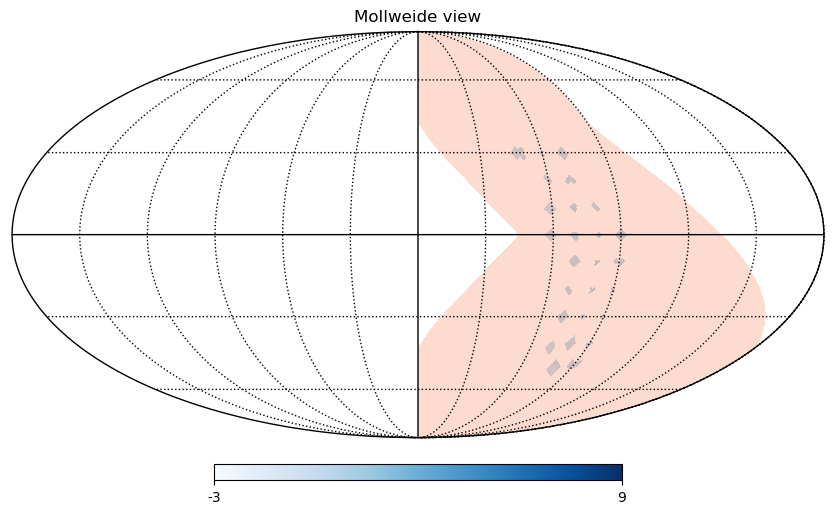

In [32]:
viz_join(o1, ipix1, o2, ipix2)

In [33]:
%timeit compute_join_pairs(skymap1, sm, omap1, om)

493 µs ± 577 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%lprun -f compute_join_pairs [compute_join_pairs(skymap1, sm, omap1, om) for _ in range(1000)]

Timer unit: 1e-09 s

Total time: 0.567098 s
File: /tmp/ipykernel_3670557/3880936369.py
Function: compute_join_pairs at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def compute_join_pairs(skymap1, skymap2, omap1, omap2):
     2                                               # Compute the partition pairs needed to perform an inner join
     3                                               # between two tables. Do it quickly (~10-100ms, even for large
     4                                               # catalogs).
     5                                               #
     6                                               # Inputs:
     7                                               #  - skymap1/2: high healpix-order counts maps of both catalogs.
     8                                               #  - omap1/2: order maps of both catalogs
     9                                               #
    10                